Epoch 1/200
37/37 [==============================] - 5s 9ms/step - loss: 0.0166
Epoch 2/200
37/37 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 3/200
37/37 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 4/200
37/37 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 5/200
37/37 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 6/200
37/37 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 7/200
37/37 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 8/200
37/37 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 9/200
37/37 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 10/200
37/37 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 11/200
37/37 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 12/200
37/37 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 13/200
37/37 [=================

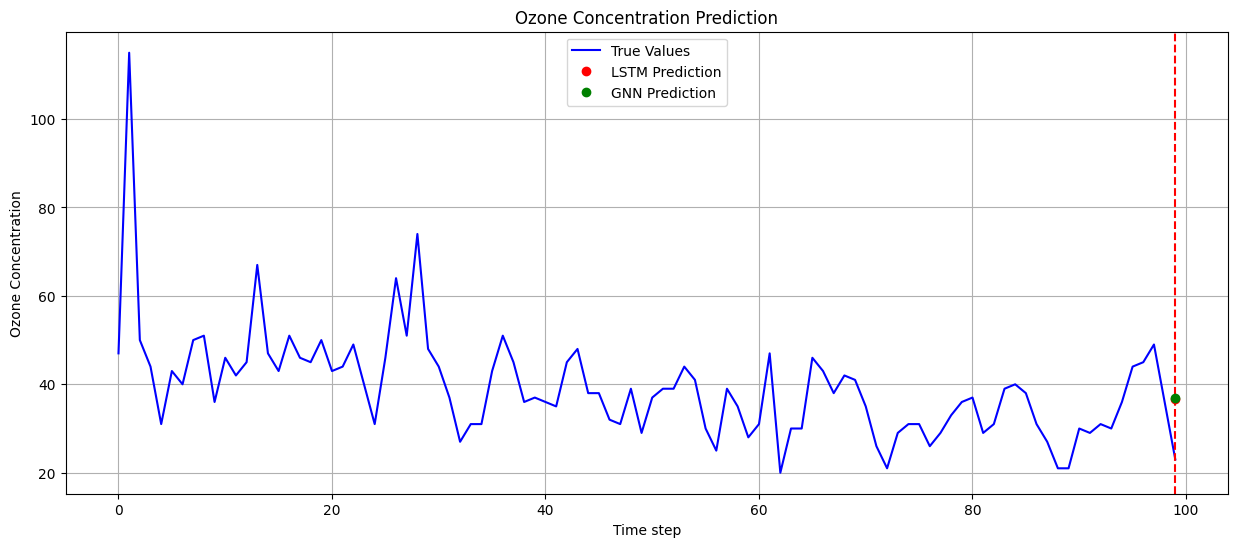

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from spektral.layers.convolutional import GCNConv as GraphConv
from spektral.utils import normalized_adjacency
import matplotlib.pyplot as plt

# Read the CSV file
dataframe = pd.read_csv('/qs.csv')
ozone_concentration = dataframe['DAILY_AQI_VALUE'].tolist()

max_value = max(ozone_concentration)
min_value = min(ozone_concentration)
normalized_data = [(x - min_value) / (max_value - min_value) for x in ozone_concentration]

# Generate graph and LSTM input data
window_size = 5
X, y = [], []
for i in range(len(normalized_data) - window_size):
    sequence = normalized_data[i:i+window_size]
    X.append([[value] for value in sequence])  # Adjusted shape to be [N, 1]
    y.append(normalized_data[i+window_size])
X = np.array(X)
y = np.array(y)

# LSTM Model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(window_size, 1), return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, y, epochs=200, verbose=1)

# LSTM Prediction
predicted_lstm = lstm_model.predict(np.expand_dims(X[-1], 0))[0][0]
predicted_value_lstm = predicted_lstm * (max_value - min_value) + min_value

# GNN Model

# Create adjacency matrix
N = window_size
adjacency_matrix = np.zeros((N, N))
for i in range(N - 1):
    adjacency_matrix[i][i+1] = 1
    adjacency_matrix[i+1][i] = 1
adjacency_matrix = normalized_adjacency(adjacency_matrix)

input_data = tf.keras.layers.Input(shape=(N, 1))
input_adj = tf.keras.layers.Input((N, N))
x = GraphConv(32, activation='relu')([input_data, input_adj])
x = GraphConv(32, activation='relu')([x, input_adj])
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1)(x)

gnn_model = tf.keras.models.Model(inputs=[input_data, input_adj], outputs=x)
gnn_model.compile(optimizer='adam', loss='mse')
gnn_model.fit([X, np.tile(adjacency_matrix, (X.shape[0], 1, 1))], y, epochs=200, verbose=1)

# GNN Prediction
predicted_gnn = gnn_model.predict([np.expand_dims(X[-1], 0), np.expand_dims(adjacency_matrix, 0)])[0][0]
predicted_value_gnn = predicted_gnn * (max_value - min_value) + min_value

print(f"Predicted ozone concentration for the next day (LSTM): {predicted_value_lstm}")
print(f"Predicted ozone concentration for the next day (GNN): {predicted_value_gnn}")

# Plotting the predictions and true values
plt.figure(figsize=(15, 6))
plt.plot(ozone_concentration[-100:], label='True Values', color='blue')
plt.axvline(x=len(ozone_concentration[-100:]) - 1, color='red', linestyle='--')
plt.plot(len(ozone_concentration[-100:]) - 1, predicted_value_lstm, 'ro', label='LSTM Prediction')
plt.plot(len(ozone_concentration[-100:]) - 1, predicted_value_gnn, 'go', label='GNN Prediction')
plt.legend()
plt.title('Ozone Concentration Prediction')
plt.xlabel('Time step')
plt.ylabel('Ozone Concentration')
plt.grid(True)
plt.show()
